In [29]:
import pickle, bz2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from utils import visualize_trajectory, get_all_trajectories, \
                  create_dataset, create_dataset_single

# Load Data

In [30]:
# Load original data
raw_trajs = pickle.load(open('./dataset/trajs_4.pkl', 'rb'))
plates = pickle.load(open('./dataset/plates_4.pkl', 'rb'))

# Visualize Trajectory Data

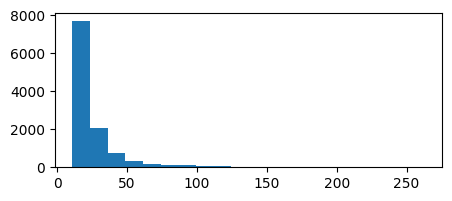

In [31]:
# Check the histogram of all trajectories to 
# decide the padding length
plate_indices = list(range(len(plates)))
days = raw_trajs[plates[0]].keys()
traj_types = ["seek", "serve"]
# Get desired trajectories
result_trajs = get_all_trajectories(raw_trajs, plates, plate_indices, days, traj_types)

# Collect all path lengths
path_lengths = []
for plate_trajs in result_trajs:
    for day_trajs in plate_trajs:
        for traj in day_trajs:
            path_lengths.append(len(traj))

# Plot histogram
plt.figure(figsize=(5, 2))
_ = plt.hist(path_lengths, bins=20)

In [32]:
def visualize_trajectory(traj, linetype='o-', shown_in_whole_map=False):
    """Draw given trajectory
    Args:
        traj: trajectory
        linetype: line type
    """
    # Skip padding zeros
    zero_rows = np.where(np.sum(traj, axis=1) == 0)[0]
    if len(zero_rows) != 0:
        start_row = zero_rows[-1] + 1
    else:
        start_row = 0

    # Get trajectory
    x = traj[start_row:, 0]
    y = traj[start_row:, 1]
    t = traj[start_row:, 2]

    # plot trajectory
    plt.plot(x, y, linetype, markersize=3)
    # plot start and end point
    plt.scatter(x[0], y[0], c='k', marker='x')
    plt.scatter(x[-1], y[-1], c='k', marker='*')
    
    # Figure settings
    if shown_in_whole_map:
        plt.xlim(0, 92)
        plt.ylim(0, 49)
    # set x, y axis scale to be the same
    plt.gca().set_aspect('equal', adjustable='box')

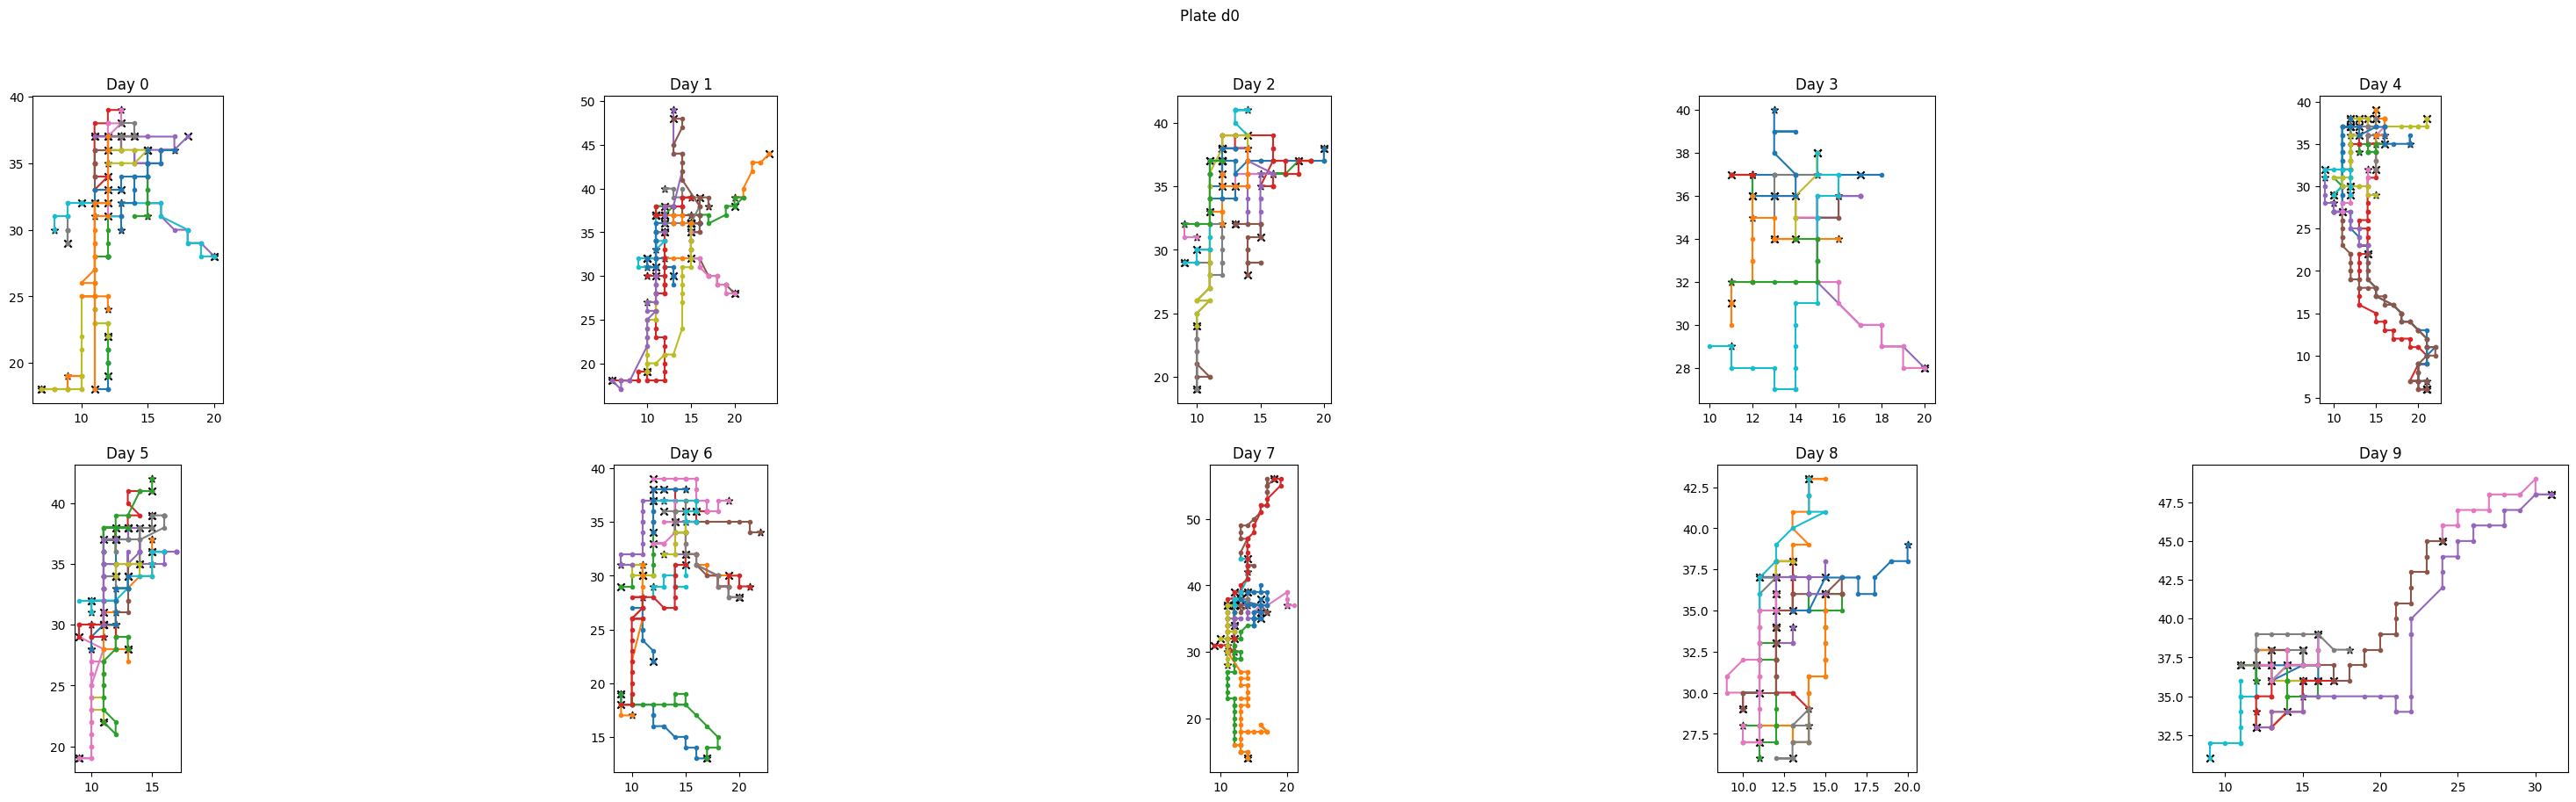

In [33]:
# Displaying trajectories of drivers on given days
plate_indices = [0]
days = list(range(10))
traj_types = ["seek", "serve"]

# Get desired trajectories
result_trajs = get_all_trajectories(raw_trajs, plates, plate_indices, days, traj_types)

# Draw a 2x5 figure of each driver's 10 day's trajectories
for plate in range(len(plate_indices)):
    plt.figure(figsize=(40, 10))
    plt.suptitle('Plate {}'.format(plates[plate_indices[plate]]))

    for day in range(len(days)):
        plt.subplot(2, 5, day+1)
        plt.title('Day {}'.format(days[day]))
        for traj in result_trajs[plate][day]:
            visualize_trajectory(np.array(traj))

# Create Data Set

In [34]:
seed = 0
random.seed(seed)
np.random.seed(seed)

# Hyper-parameter
from argument import create_parser
parser = create_parser()
opts = parser.parse_args(args=[])
plate_indices = list(range(len(plates)))

# Select days for training, validation and testing
num_days = len(raw_trajs[plates[0]].keys())  # 111 days
indices = np.random.permutation(np.arange(num_days))
train_days = indices[0: 90]
val_days = indices[90: 95]
test_days = indices[95:111]

# Create training dataset
X_train, y_train = create_dataset_single(
    raw_trajs, plates, 
    plate_indices=plate_indices, 
    selected_days=train_days, 
    traj_type=opts.traj_type, num_trajs=opts.num_trajs,
    padding_length=opts.padding_length)
# Create validation dataset
X_val, y_val = create_dataset_single(
    raw_trajs, plates,
    plate_indices=plate_indices, 
    selected_days=val_days, 
    traj_type=opts.traj_type, num_trajs=opts.num_trajs,
    padding_length=opts.padding_length)
#Create testing dataset
X_test, y_test = create_dataset_single(
    raw_trajs, plates, 
    plate_indices=plate_indices, 
    selected_days=test_days, 
    traj_type=opts.traj_type, num_trajs=opts.num_trajs,
    padding_length=opts.padding_length
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Save the datasets
pickle.dump([X_train.astype(int), y_train.astype(int)], bz2.open('./dataset/classification_training_set.pkl', 'wb'))
pickle.dump([X_val.astype(int), y_val.astype(int)], bz2.open('./dataset/classification_validation_set.pkl', 'wb'))
pickle.dump([X_test.astype(int), y_test.astype(int)], bz2.open('./dataset/classification_testing_set.pkl', 'wb'))

[ 99  10  76   2  24 102  45   7  16  90  89  22  43  51  61  54  13  74
  92  60  95   8  26  59  33   3 106  86  30   6  48  91 105  96  73  56
  27  18  63  52  78  82  85 110   1  66  42  41   4  15  17  40  38   5
  53 101  68   0  34  28  55  50  11  62  35  23  31  71  57  84  94  32
  93  14  75  19  29  49 108 109  79  69  80  20 104  72  77  25  37  81
  97  46 100  39  65  58  12  98  88  70  87  36  21  83   9 103 107  67
  64  47  44]
(360, 10, 60, 3)
(360, 1)
(20, 10, 60, 3)
(20, 1)
(64, 10, 60, 3)
(64, 1)


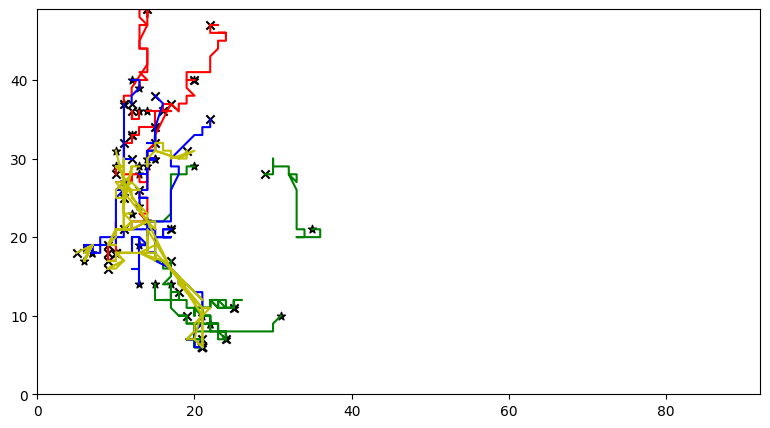

In [35]:
plt.figure(figsize=(10, 5))

colors = ['r', 'g', 'b', 'y', 'c']
for i, sample in enumerate(X_val):
    day = int( i % 5 )
    if (day != 0): continue

    for t, traj in enumerate(sample):
        visualize_trajectory(
            traj, linetype=colors[int(y_val[i])]+'-', 
            shown_in_whole_map=True)
plt.show()